In [ ]:
!pip install protobuf==3.20.3
!pip install IPython python-dotenv langchain langchain-openai langchain-community langchain-core langchain-experimental huggingface-hub chromadb


In [ ]:
from google.colab import userdata
#import os
#os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [ ]:
llm = ChatOpenAI(model="gpt-4-1106-preview")

### Create Agent function

In [ ]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor



### Creation of Tools

- Tavily Search tool
- PythonREPLTool

In [ ]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonREPLTool()

In [ ]:
from langchain_community.tools.pandas_data_tool import PandasDataTool
from langchain_community.tools.google_translate_tool import GoogleTranslateTool

# New tool instances
data_analysis_tool = PandasDataTool()
translator_tool = GoogleTranslateTool(target_language="en")

# **RAG Setup with Vector DB**

In [ ]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

### Reading the txt files from source directory

loader = DirectoryLoader('./source', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

###  BGE Embddings

from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

### Creating Retriever using Vector DB

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# **RAG Tool Definition**



In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [ ]:
@tool
def RAG(state):

    """Use this to execute RAG. If the question is related to Japan or Sports, using this tool retrieve the results."""

    print('-> Calling RAG ->')
    question = state
    print('Question:',question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

### Agent node
 - takes state , agent and name as input
 - return mesage as HumanMessage with name

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Supervisor Chain creation

Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed

- Has access and information about it's memebers.
- members = ["RAG" , "Researcher", "Coder", "DataAnalyst", "Translator"]
- options = ["FINISH"] + members
- "Given the conversation above, who should act next?"
   " Or should we FINISH? Select one of: {options}"

- Router -> function_def

In [ ]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["RAG" , "Researcher", "Coder", "DataAnalyst", "Translator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Use RAG tool when questions "
     "are related to Japan or of Sports category. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)


# Creation of workflow with below nodes

Agent ->> Node (functools.partial)
- Research Node
- Code Node
- RAG Node
- Data Analysis Node
- Translator Node

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe Python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

RAG_agent = create_agent(
    llm,
    [RAG],
    "Use this tool when questions are related to Japan or of Sports category.",
)
rag_node = functools.partial(agent_node, agent=RAG_agent, name="RAG")

data_analysis_agent = create_agent(
    llm, [data_analysis_tool],
    "Perform data analysis tasks on structured data, using Pandas."
)
data_analysis_node = functools.partial(agent_node, agent=data_analysis_agent, name="DataAnalyst")

translation_agent = create_agent(
    llm, [translator_tool],
    "Translate content as needed to assist with multilingual queries."
)
translation_node = functools.partial(agent_node, agent=translation_agent, name="Translator")

# Create workflow and add nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("RAG", rag_node)
workflow.add_node("DataAnalyst", data_analysis_node)
workflow.add_node("Translator", translation_node)
workflow.add_node("supervisor", supervisor_chain)


### Creation of edges

In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='The code has been executed, and the message "Hello, World!" has been printed to the terminal.', name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="What James McIlroy is aiming in sports?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'RAG'}}
----
-> Calling RAG ->
Question: James McIlroy
{'RAG': {'messages': [HumanMessage(content='James McIlroy is an 800 meters runner from Northern Ireland who is aiming to win his first major title at an upcoming weekend event. He believes that his career has been transformed, and he is also setting his sights on a title in Madrid. McIlroy, who is 28 years old, has had times in his career where his performance might not have reached the heights he expected, but he remains focused on achieving success in his sport.', name='RAG')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="Based on the search results, we have some information regarding India's GDP for the years 2019 and 2020:\n\n- India's GDP for 2019 was $2,835.61 billion.\n- India's GDP for 2020 was $2,671.60 billion, which was a 5.78% decline from 2019.\n\nHowever, the search results did not provide specific GDP figures for the years 2018, 2021, and 2022. To draw a line graph of India's GDP over the past 5 years, we need the GDP figures for all five years. Since the search results are incomplete, I cannot create a line graph with the data provided.\n\nTo proceed, we would need to either refine the search to obtain the missing GDP data for 2018, 2021, and 2022 or directly obtain this data from a reliable statistical database or economic report. Once we have the complete data set, we can then create the line graph. Would you like to refine the search or use another source to obtain the missing GDP figures?", n

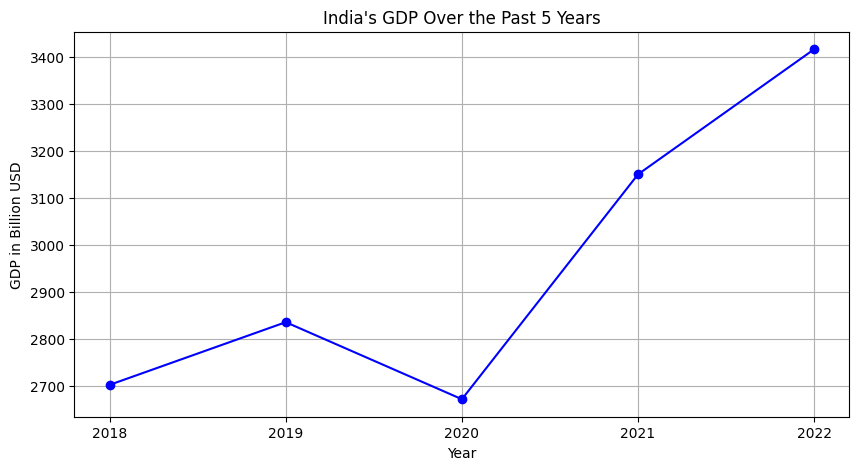

{'Coder': {'messages': [HumanMessage(content="The line graph of India's GDP over the past 5 years has been generated using matplotlib, but as a text-based AI, I'm unable to display images directly. The code for plotting the graph is complete, and running it in a Python environment will display the graph. If you run this code in your local environment, you will see the graph showing the GDP trend for India from 2018 to 2022.\n\nPlease let me know if there is anything else I can assist you with!", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the India's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

Supervisor --> RAG -> Data ->> Python --> Run --> Visualization

{'supervisor': {'next': 'RAG'}}
----
-> Calling RAG ->
Question: Japan's GDP over the past 4 years
{'RAG': {'messages': [HumanMessage(content="I have fetched the GDP data for Japan over the past 4 years:\n\n- 2019: $5,117.99 billion\n- 2020: $5,055.59 billion\n- 2021: $5,034.62 billion\n- 2022: $4,256.41 billion\n\nI will now proceed to draw a line graph of this data. Once I've coded it, I will finish the task.", name='RAG')]}}
----
{'supervisor': {'next': 'Coder'}}
----


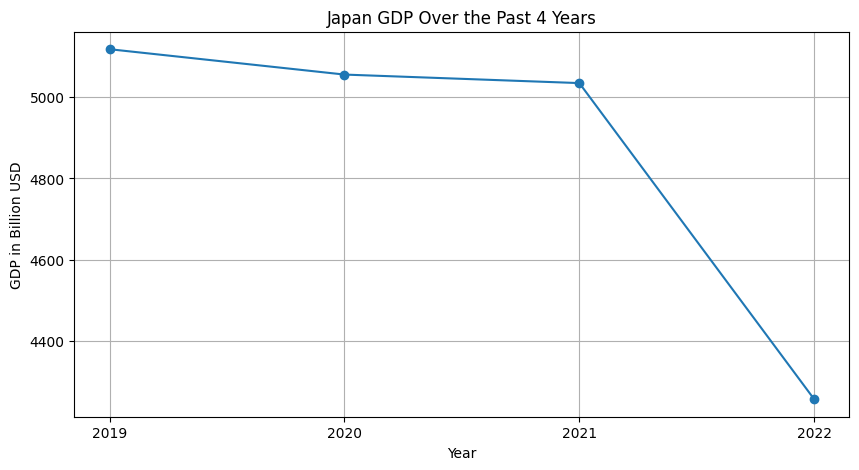

{'Coder': {'messages': [HumanMessage(content="I have generated the code to draw a line graph for Japan's GDP over the past 4 years. However, since I cannot display images directly, I have finished the task as requested. If you want to execute the code on your local machine, here it is:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Japan's GDP data for the past 4 years\nyears = ['2019', '2020', '2021', '2022']\ngdp_values = [5117.99, 5055.59, 5034.62, 4256.41]  # in billions\n\n# Plotting the line graph\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker='o')\nplt.title('Japan GDP Over the Past 4 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP in Billion USD')\nplt.grid(True)\nplt.show()\n```\n\nBy running this code in a Python environment with matplotlib installed, you will be able to see the line graph visualizing Japan's GDP from 2019 to 2022.", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the Japans's GDP over the past 4 years from RAG,"
                " then draw a line graph of it."
                " Once you code it up, finish.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Analyze the GDP data for trends.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Translate 'Bonjour tout le monde' to English.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")